<a href="https://colab.research.google.com/github/Avians01/Centralized-repository-shipping_calculations/blob/main/Copy_of_SAM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import urllib.request
from pathlib import Path

print("Starting SAM2 setup...")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


Starting SAM2 setup...
PyTorch version: 2.8.0+cu126
CUDA available: True


In [ ]:
# Clean install to avoid setup.py errors
!rm -rf /content/sam2
!git clone https://github.com/facebookresearch/sam2.git
%cd /content/sam2
!pip install -e .
!pip install opencv-python matplotlib

# Add SAM2 to Python path
if '/content/sam2' not in sys.path:
    sys.path.append('/content/sam2')


Cloning into 'sam2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 24.66 MiB/s, done.
Resolving deltas: 100% (381/381), done.
/content/sam2
Obtaining file:///content/sam2


In [ ]:
checkpoint_dir = Path('./checkpoints')
checkpoint_dir.mkdir(exist_ok=True)

checkpoint_path = checkpoint_dir / 'sam2_hiera_large.pt'
if not checkpoint_path.exists():
    print("Downloading SAM2 model checkpoint...")
    checkpoint_url = "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt"
    urllib.request.urlretrieve(checkpoint_url, checkpoint_path)
    print(f"Downloaded checkpoint to {checkpoint_path}")


Downloaded checkpoint to checkpoints/sam2_hiera_large.pt


In [ ]:
from sam2.build_sam import build_sam2_video_predictor

In [ ]:
def download_sample_video():
    video_dir = Path('./videos')
    video_dir.mkdir(exist_ok=True)
    video_path = video_dir / 'sample_video.mp4'

    if not video_path.exists():
        print("Downloading sample video...")
        video_url = "https://sample-videos.com/zip/10/mp4/SampleVideo_1280x720_1mb.mp4"
        try:
            urllib.request.urlretrieve(video_url, video_path)
            print(f"Downloaded video to {video_path}")
        except:
            print("Failed to download sample video. Please upload your own video.")
            return None
    return str(video_path)

video_path = download_sample_video()


Failed to download sample video. Please upload your own video.


In [ ]:
def download_sample_video():
    video_dir = Path('./videos')
    video_dir.mkdir(exist_ok=True)
    video_path = video_dir / 'sample_video.mp4'

    if not video_path.exists():
        print("Downloading sample video...")
        video_url = "https://github.com/cheind/py-thin-plate-spline/raw/master/data/face.mp4"
        try:
            urllib.request.urlretrieve(video_url, video_path)
            print(f"Downloaded video to {video_path}")
        except Exception as e:
            print("Failed to download sample video:", e)
            return None
    return str(video_path)

video_path = download_sample_video()


Failed to download sample video: HTTP Error 404: Not Found


In [ ]:
from google.colab import files

uploaded = files.upload()
video_path = list(uploaded.keys())[0]  # picks the uploaded file
print("Using uploaded video:", video_path)


Saving 04_coffee.mp4 to 04_coffee.mp4
Using uploaded video: 04_coffee.mp4


In [ ]:
def extract_frames_from_video(video_path, output_dir):
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_path = output_dir / f"frame_{frame_count:05d}.jpg"
        Image.fromarray(frame_rgb).save(frame_path)
        frames.append(str(frame_path))
        frame_count += 1

    cap.release()
    print(f"Extracted {frame_count} frames to {output_dir}")
    return frames

def display_frames_with_masks(frames, masks, max_frames=5):
    num_frames = min(len(frames), max_frames)
    fig, axes = plt.subplots(2, num_frames, figsize=(3*num_frames, 6))
    if num_frames == 1:
        axes = axes.reshape(-1, 1)

    for i in range(num_frames):
        frame = Image.open(frames[i])
        axes[0, i].imshow(frame)
        axes[0, i].set_title(f'Frame {i}')
        axes[0, i].axis('off')

        if i < len(masks) and masks[i] is not None:
            axes[1, i].imshow(masks[i], cmap='viridis')
            axes[1, i].set_title(f'Mask {i}')
        else:
            axes[1, i].text(0.5, 0.5, 'No mask', ha='center', va='center')
            axes[1, i].set_title(f'Mask {i}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
def initialize_sam2_predictor():
    print("Initializing SAM2 video predictor...")
    sam2_checkpoint = "./checkpoints/sam2_hiera_large.pt"
    model_cfg = "sam2_hiera_l.yaml"
    predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint)
    print("SAM2 predictor initialized successfully!")
    return predictor

predictor = initialize_sam2_predictor()


Initializing SAM2 video predictor...
SAM2 predictor initialized successfully!


Running SAM2 inference on video: 04_coffee.mp4
Extracted 287 frames to ./frames
Processing 287 frames...


frame loading (JPEG): 100%|██████████| 287/287 [00:11<00:00, 25.82it/s]


Adding prompt at point (640, 360) on frame 0
Propagating segmentation through video frames...


propagate in video: 100%|██████████| 287/287 [04:20<00:00,  1.10it/s]


Inference complete!
Displaying results...


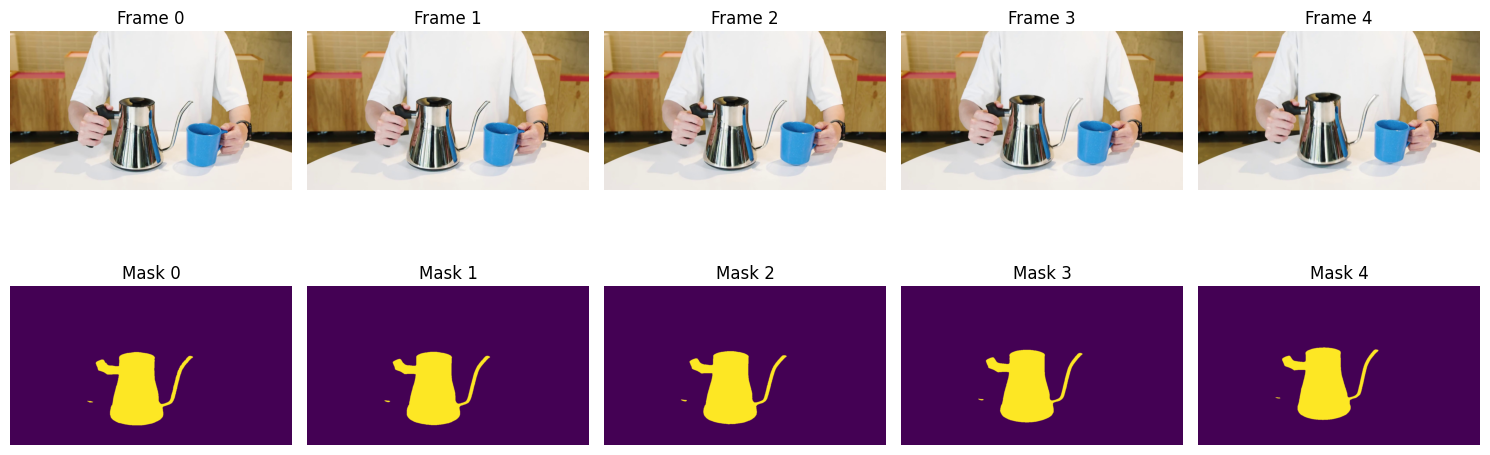

Successfully processed 287 frames
Generated masks for 287 frames
Objects tracked: [1]


In [ ]:
def run_sam2_inference(video_path, predictor):
    frames_dir = "./frames"
    frames = extract_frames_from_video(video_path, frames_dir)
    if not frames:
        print("No frames extracted from video")
        return None, None

    print(f"Processing {len(frames)} frames...")
    inference_state = predictor.init_state(video_path=frames_dir)

    frame_idx = 0
    first_frame = Image.open(frames[0])
    width, height = first_frame.size

    obj_id = 1
    points = np.array([[width//2, height//2]], dtype=np.float32)
    labels = np.array([1], np.int32)

    print(f"Adding prompt at point ({width//2}, {height//2}) on frame {frame_idx}")

    _, out_obj_ids, out_mask_logits = predictor.add_new_points(
        inference_state=inference_state,
        frame_idx=frame_idx,
        obj_id=obj_id,
        points=points,
        labels=labels,
    )

    print("Propagating segmentation through video frames...")
    video_segments = {}
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }

    print("Inference complete!")
    return frames, video_segments

if video_path and os.path.exists(video_path):
    print(f"Running SAM2 inference on video: {video_path}")
    frames, video_segments = run_sam2_inference(video_path, predictor)

    if frames and video_segments:
        masks = []
        for i in range(min(len(frames), 5)):
            if i in video_segments and 1 in video_segments[i]:
                mask = video_segments[i][1][0]
                masks.append(mask)
            else:
                masks.append(None)

        print("Displaying results...")
        display_frames_with_masks(frames, masks)
        print(f"Successfully processed {len(frames)} frames")
        print(f"Generated masks for {len(video_segments)} frames")
        print(f"Objects tracked: {list(video_segments[0].keys()) if video_segments else 'None'}")


In [ ]:
print("\n" + "="*60)
print("TO USE YOUR OWN VIDEO:")
print("1. Upload your video file to Colab")
print("2. Update the 'video_path' variable with your video's path")
print("3. Modify the prompt points in run_sam2_inference()")
print("4. Re-run the inference")
print("="*60)

# Example:
# custom_video_path = "/content/your_video.mp4"
# if os.path.exists(custom_video_path):
#     frames, video_segments = run_sam2_inference(custom_video_path, predictor)



TO USE YOUR OWN VIDEO:
1. Upload your video file to Colab
2. Update the 'video_path' variable with your video's path
3. Modify the prompt points in run_sam2_inference()
4. Re-run the inference
